In [1]:
from PIL import Image
import cv2
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.ops import nms
from torchvision import transforms

from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

In [3]:
DEVICE=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda', index=0)

In [4]:
class D_DETRModel(nn.Module):
    def __init__(self, num_classes=1, model='detr_resnet50'):
        super(D_DETRModel, self).__init__()
        self.num_classes = num_classes
        self.model = torch.hub.load(
            'facebookresearch/detr', 
            model, 
            pretrained=False,
        )
        self.out = nn.Linear(
            in_features=self.model.class_embed.out_features, 
            out_features=num_classes
        )
        
    def forward(self, images):
        d = self.model(images)
        d['pred_logits'] = self.out(d['pred_logits'])
        return d
    
    def parameter_groups(self):
        return { 
            'backbone': [p for n,p in self.model.named_parameters()
                              if ('backbone' in n) and p.requires_grad],
            'transformer': [p for n,p in self.model.named_parameters() 
                                 if (('transformer' in n) or ('input_proj' in n)) and p.requires_grad],
            'embed': [p for n,p in self.model.named_parameters()
                                 if (('class_embed' in n) or ('bbox_embed' in n) or ('query_embed' in n)) 
                           and p.requires_grad],
            'final': self.out.parameters()
        }

In [5]:
weights_path='/opt/quantum/vision_transformers/runs/training/detr_resnet50/best_model.pth'
num_classes=6
model = D_DETRModel(num_classes=6, model='detr_resnet50')
ckpt = torch.load(weights_path)
model.load_state_dict(ckpt['model_state_dict'])

Using cache found in /home/fgerard/.cache/torch/hub/facebookresearch_detr_main
/home/fgerard/anaconda3/envs/vision_transformers/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fgerard/anaconda3/envs/vision_transformers/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [6]:
r_model=model.eval().to(DEVICE)

In [7]:
CLASSES = ["tractor","caja","cortina","llanta","producto"]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [8]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox_xyxy, size):
    img_w, img_h = size
    b = out_bbox_xyxy * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32).to(DEVICE)
    return b

def create_objects(prob,boxes):
    result=[]
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        cl = p.argmax()
        prob = p[cl].item()*100
        result.append([int(cl),int(prob),int(xmin),int(ymin),int(xmax),int(ymax)])
    return result


In [9]:
def detect(im, model, transform, min_score=0.7, iou_threshold=0.5):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0).to(DEVICE)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > min_score

    ## hacer NMS
    max_score_values=probas.max(-1).values
    boxes_xyxy=box_cxcywh_to_xyxy(outputs['pred_boxes'][0])
    
    #print("probas: {} {}".format(max_score_values.shape,max_score_values))
    #print("boxes_xyxy: {} {}".format(boxes_xyxy.shape,boxes_xyxy))
    
    good_index=nms(boxes=boxes_xyxy,scores=max_score_values, iou_threshold=iou_threshold)
    
    #print("good_index: {} {}".format(good_index.shape,good_index))

    d_keep=torch.zeros(100, dtype=torch.bool).to(DEVICE)
    d_keep[good_index]=True
    #print("keep: {} {} {}".format(keep.shape,keep,torch.sum(keep).item()))
    #print("d_keep: {} {} {}".format(d_keep.shape,d_keep,torch.sum(d_keep).item()))
    keep = torch.logical_and(keep, d_keep)
    #print("2keep: {} {} {}".format(keep.shape,keep,torch.sum(keep).item()))

    bboxes_scaled = rescale_bboxes(boxes_xyxy[keep], im.size)
    return probas[keep], bboxes_scaled

In [10]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=6,bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [13]:
ims = [
    Image.open("/mnt/disco2T/opt.old/develop/DATASETS/aduana/dataset-git/output-voc.bk/val/val.000000.jpg"),
    Image.open("/mnt/disco2T/opt.old/develop/DATASETS/aduana/dataset-git/output-voc.bk/val/val.000001.jpg"),
    Image.open("/mnt/disco2T/opt.old/develop/DATASETS/aduana/dataset-git/output-voc.bk/val/val.000002.jpg")
]
idx=1
im = ims[idx]
#scores, boxes = detect(im, detr, transform,min_score=0.85)
scores, boxes = detect(im, r_model, transform,min_score=0.5)

result=create_objects(scores,boxes)
print(torch.tensor(result).shape)
result

torch.Size([5, 6])


[[3, 71, 289, 166, 347, 209],
 [3, 73, 1, 152, 38, 195],
 [2, 98, 2, 38, 235, 174],
 [1, 99, 8, 33, 465, 180],
 [4, 74, 212, 72, 382, 165]]

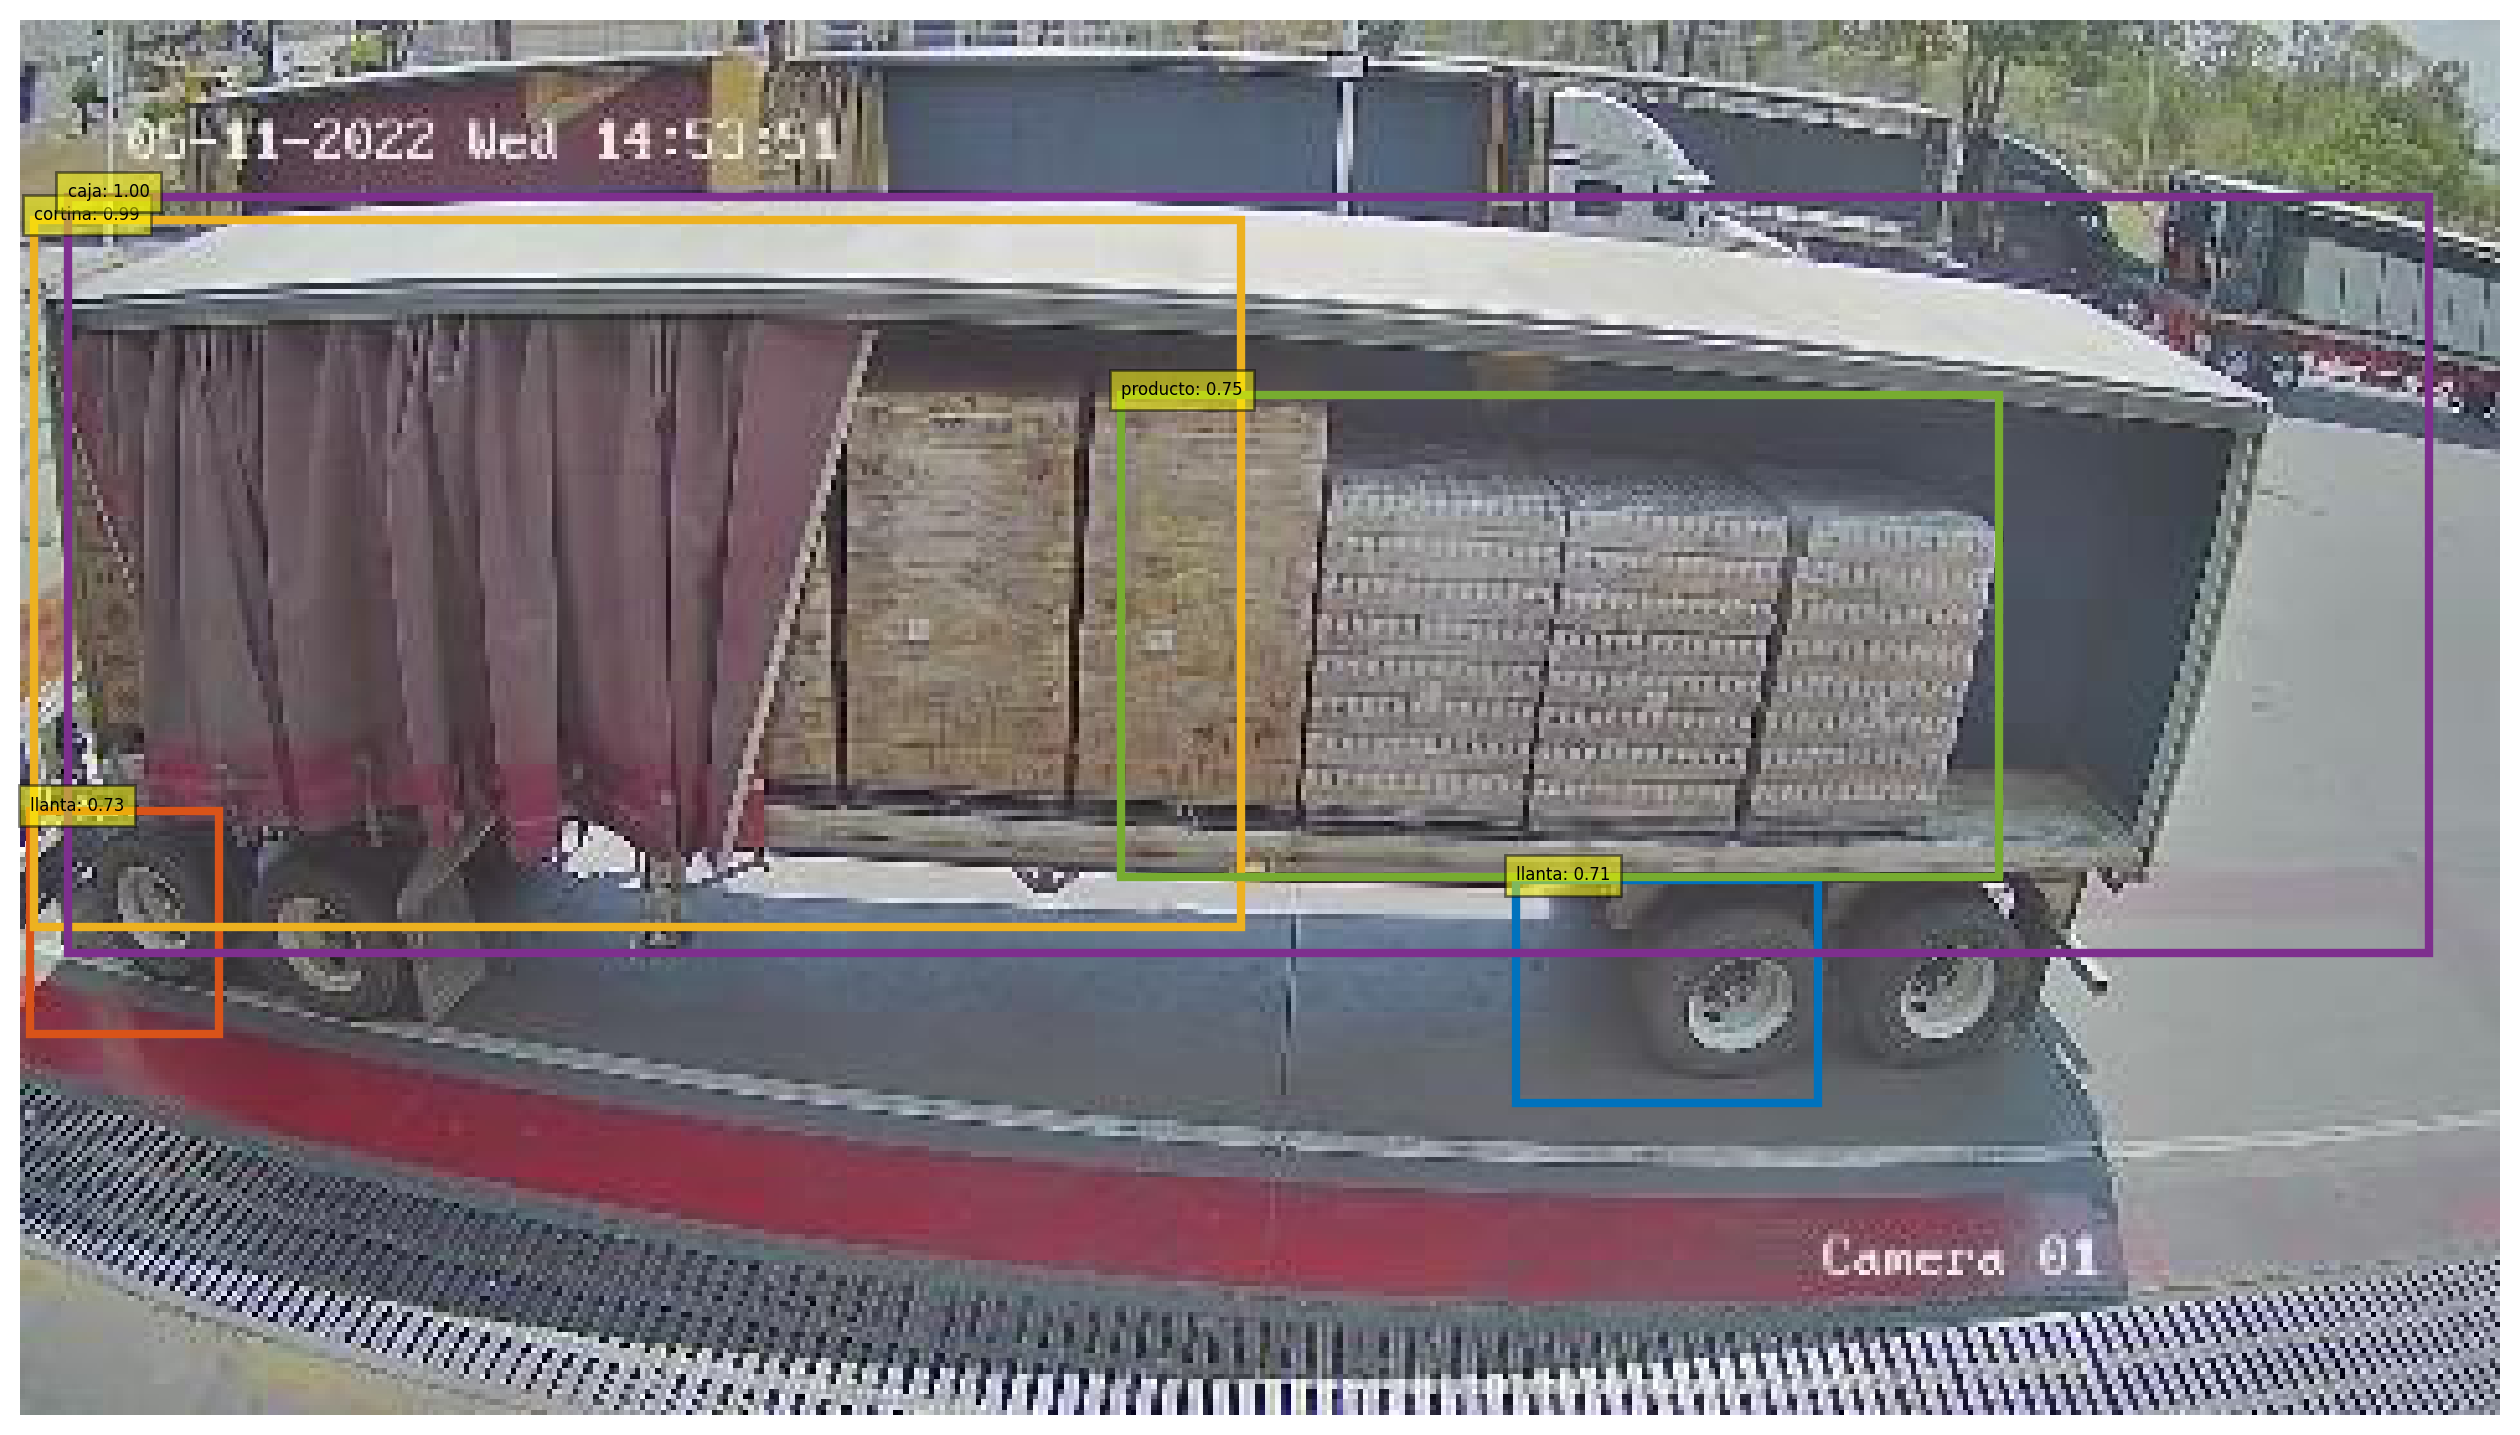

In [14]:
plot_results(im, scores, boxes)